In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import datetime
import pytz
import random

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import torch
from PIL import Image
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [4]:
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset,random_split
from skimage import io, transform
import torchvision.transforms as transforms
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [6]:
train_images = 1000
test_images = 200

csv_PATH = "/kaggle/input/diabetic-retinopathy-resized/trainLabels_cropped.csv"
images_PATH = "/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/"

In [7]:
df = pd.read_csv(csv_PATH)
df.head()

Unnamed: 0  Unnamed: 0.1     image  level
0           0             0   10_left      0
1           1             1  10_right      0
2           2             2   13_left      0
3           3             3  13_right      0
4           4             4   15_left      1

In [8]:
import torchvision.transforms as transforms

c_trans = transforms.Compose([ # For ImageFolder
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])


d_trans = transforms.Compose([ # For the dataset class
    transforms.ToPILImage(), ## WE NEED THIS OR ELSE IT GIVES TYPE ERROR WITH NUMPY NDARRAY
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
cropped_new_df = pd.read_csv(csv_PATH)
cropped_new_df.head()

Unnamed: 0  Unnamed: 0.1     image  level
0           0             0   10_left      0
1           1             1  10_right      0
2           2             2   13_left      0
3           3             3  13_right      0
4           4             4   15_left      1

In [10]:
import torch
from PIL import Image

class retinaDataset(Dataset):
    def __init__(self, imagepath = images_PATH, start = 0, total = None, transform = None):
        self.df = cropped_new_df
        
        if (total is not None):
            self.df = self.df[start:total]
        
        self.transform = transform
        
        self.imagepath = imagepath
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.imagepath, self.df.iloc[index].image +".jpeg")
        # img = Image.open(img_path) # Old
        img = io.imread(img_path) # New
        img = torch.from_numpy(img).permute(2, 0, 1)
        
        if(self.transform):
            img = self.transform(img)
        
        return img, torch.tensor(self.df.iloc[index].level)

In [11]:
trainset_DS = retinaDataset(total = train_images, transform = d_trans)
testset_DS = retinaDataset(start = train_images, total = train_images + test_images, transform = d_trans)
print(len(trainset_DS))
print(len(testset_DS))
print()
trainloader_DS = DataLoader(dataset=trainset_DS, batch_size = len(trainset_DS), shuffle=True)
testloader_DS = DataLoader(dataset=testset_DS, batch_size = len(testset_DS), shuffle=True)
print(len(trainloader_DS))
print(len(testloader_DS))

1000
200

1
1


0 torch.Size([3, 224, 224]) tensor(0)
1 torch.Size([3, 224, 224]) tensor(0)
2 torch.Size([3, 224, 224]) tensor(0)
3 torch.Size([3, 224, 224]) tensor(0)


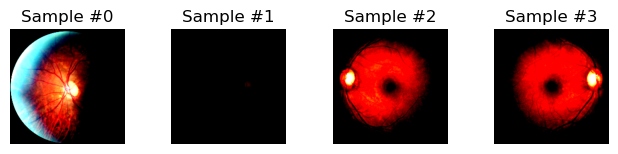

In [12]:
# Verify both sets
mode = "test"
mode = "train"

if mode == "train":
    set = trainset_DS
else:
    set = testset_DS
fig = plt.figure()
limit = 4
for i in range(len(set)):
    img, label = set[i]

    print(i, img.shape, label)

    ax = plt.subplot(1, limit, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(img.permute(1,2,0))
    if i == limit - 1:
        plt.show()
        break

In [13]:
def reshape_correctly(X_prub):
    shap = X_prub.shape
    shap_new = (shap[0], shap[2], shap[3], shap[1])
    X_prub = X_prub.reshape(shap_new)
    
    return X_prub


In [14]:
X_priv = next(iter(trainloader_DS))[0].numpy()
X_pub = next(iter(testloader_DS))[0].numpy()

X_priv_lab = next(iter(trainloader_DS))[1].numpy()
X_pub_lab = next(iter(testloader_DS))[1].numpy()

X_priv = reshape_correctly(X_priv)
X_pub = reshape_correctly(X_pub)

X_priv_lab.shape

(1000,)

In [15]:
import tensorflow as tf

In [16]:
XD_priv = tf.data.Dataset.from_tensor_slices((X_priv, X_priv_lab))
XD_pub = tf.data.Dataset.from_tensor_slices((X_pub, X_pub_lab))

In [17]:
print(len(XD_priv))

1000


In [18]:
print(X_priv.shape)
print(X_pub.shape)

(1000, 224, 224, 3)
(200, 224, 224, 3)


# Attack Part

In [19]:
!git clone https://github.com/pasquini-dario/SplitNN_FSHA.git
os.chdir("SplitNN_FSHA")

Cloning into 'SplitNN_FSHA'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 116 (delta 59), reused 64 (delta 7), pack-reused 0
Receiving objects: 100% (116/116), 1.05 MiB | 7.40 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [20]:
import tensorflow as tf
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import SplitNN_FSHA

from SplitNN_FSHA import datasets as datasets
from SplitNN_FSHA import architectures as architectures
from SplitNN_FSHA import FSHA as FSHA # Attack
from SplitNN_FSHA import FSHA_distcor as FSHA_distcor # Defense Technique


In [21]:
batch_size = 4
id_setup = 4
hparams = {
    'WGAN' : True,
    'gradient_penalty' : 500.,
    'style_loss' : None,
    'lr_f' :  0.00001,
    'lr_tilde' : 0.00001,
    'lr_D' : 0.0001,
}

fsha_attack = FSHA.FSHA(XD_priv, XD_pub, id_setup-1, batch_size, hparams)

[PILOT] activation:  None
[DECODER] activation:  None


In [22]:
log_frequency = 500
iterations = 10000
LOG1 = fsha_attack(iterations, verbose=True, progress_bar=False, log_frequency=log_frequency)

RUNNING...
Use WGAN loss
Use GP
Use WGAN loss
Use GP
log--00%-0000000] validation: 1.5844
log--05%-0000500] validation: 0.9826
log--10%-0001000] validation: 0.4656
log--15%-0001500] validation: 0.4304
log--20%-0002000] validation: 0.4075
log--25%-0002500] validation: 0.3955
log--30%-0003000] validation: 0.3770
log--35%-0003500] validation: 0.3692
log--40%-0004000] validation: 0.3530
log--45%-0004500] validation: 0.3559
log--50%-0005000] validation: 0.3443
log--55%-0005500] validation: 0.3519
log--60%-0006000] validation: 0.3462
log--65%-0006500] validation: 0.3391
log--70%-0007000] validation: 0.3438
log--75%-0007500] validation: 0.3347
log--80%-0008000] validation: 0.3422
log--85%-0008500] validation: 0.3327
log--90%-0009000] validation: 0.3351
log--95%-0009500] validation: 0.3338


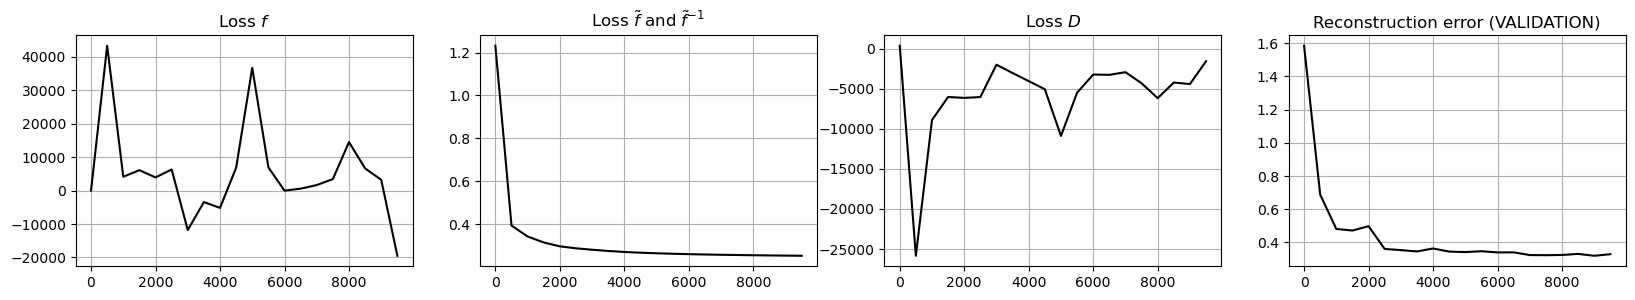

In [23]:
def plot_log(ax, x, y, label):
    ax.plot(x, y, color='black')
    ax.set(title=label)
    ax.grid()

n = 4
fix, ax = plt.subplots(1, n, figsize=(n*5, 3))
x = np.arange(0, len(LOG1)) * log_frequency 

plot_log(ax[0], x, LOG1[:, 0], label='Loss $f$')
plot_log(ax[1], x, LOG1[:, 1],  label='Loss $\\tilde{f}$ and $\\tilde{f}^{-1}$')
plot_log(ax[2], x, LOG1[:, 2],  label='Loss $D$')
plot_log(ax[3], x, LOG1[:, 3],  label='Reconstruction error (VALIDATION)')

## Save Results

In [24]:
results_dic = {"X_Axis":[],
               "Mode":[],
               "Loss $f$":[],
               "Loss $\\tilde{f}$ and $\\tilde{f}^{-1}$":[],
               "Loss $D$":[],
               "Reconstruction error (VALIDATION)":[]}

def update_results(results_dic, LOG, log_frequency = 500, mode = "Attack"):
    results_dic["X_Axis"].append(np.arange(0, len(LOG)) * log_frequency)
    results_dic["Mode"].append(mode)
    results_dic["Loss $f$"].append(list(LOG[:, 0]))
    results_dic["Loss $\\tilde{f}$ and $\\tilde{f}^{-1}$"].append(list(LOG[:, 1]))
    results_dic["Loss $D$"].append(list(LOG[:, 2]))
    results_dic["Reconstruction error (VALIDATION)"].append(list(LOG[:, 3]))
    
    return results_dic


results_dic = update_results(results_dic, LOG1, log_frequency = 500, mode = "Attack")
df = pd.DataFrame(results_dic)
df.to_csv("/kaggle/working/Attack_Logs.csv")
print("ATTACK LOG SAVED!")

ATTACK LOG SAVED!


## Malicious Reconstruction

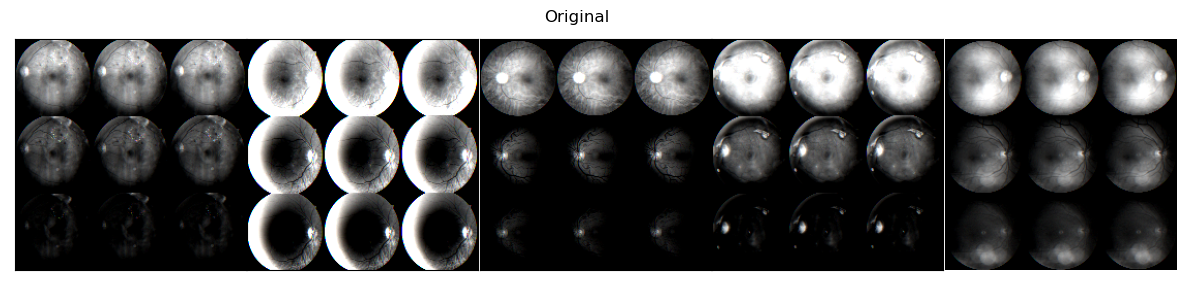

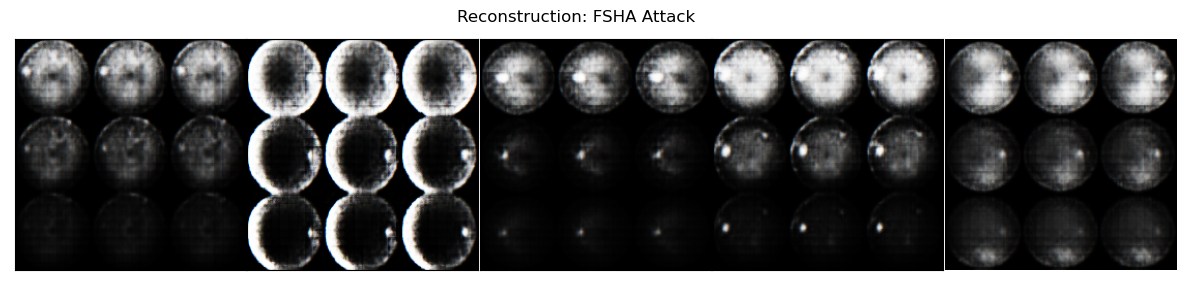

In [25]:
n = 5
X = SplitNN_FSHA.datasets.getImagesDS(XD_priv, n)
X_recovered_attack, control = fsha_attack.attack(X)

def plot(X, title):
    n = len(X)
    X = (X+1)/2
#     plt.title("Cunt")
    fig, ax = plt.subplots(1, n, figsize=(n*3,3))
    fig.suptitle(title)
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-.05)
    for i in range(n):
        ax[i].imshow((X[i]), cmap='inferno');  
        ax[i].set(xticks=[], yticks=[])
        ax[i].set_aspect('equal')
        
    return fig

fig = plot(X, "Original")
plt.savefig('/kaggle/working/Original1.pdf')
plt.savefig('/kaggle/working/Original1.png')
fig = plot(X_recovered_attack, "Reconstruction: FSHA Attack")
plt.savefig('/kaggle/working/Reconstruction_Attack.png')
plt.savefig('/kaggle/working/Reconstruction_Attack.pdf')

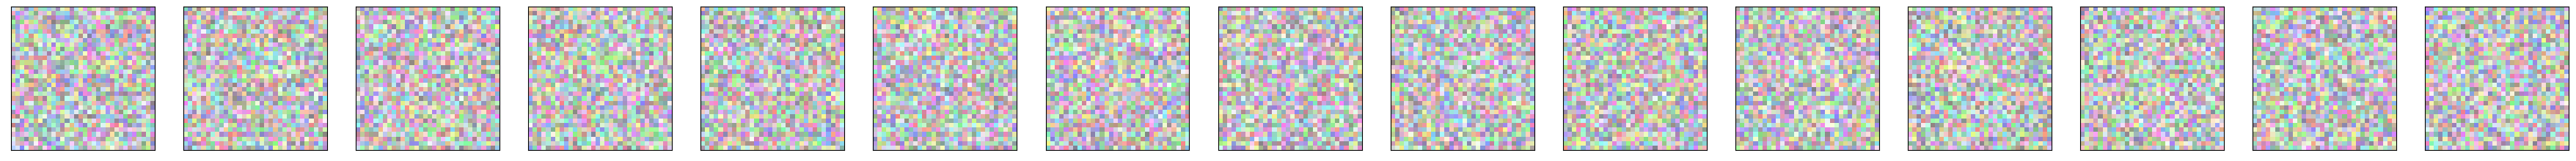

In [26]:
X_prub = np.random.rand(15, 3, 32, 32)

def reshape_correctly(X_prub):
    shap = X_prub.shape
    shap_new = (shap[0], shap[2], shap[3], shap[1])
    X_prub = X_prub.reshape(shap_new)
    
    return X_prub

X_prub = reshape_correctly(X_prub)

SplitNN_FSHA.datasets.plot(X_prub)

# Defense Part

In [27]:
batch_size = 4
id_setup = 4
hparams = {
    
    'alpha1' : 10000, # Extremely high value for alpha1
    'alpha2' : 50,    # Attacker scales adversarial loss to overwrite alpha1
    
    'WGAN' : True,
    'gradient_penalty' : 500.,
    'style_loss' : None,
    'lr_f' :  0.00001,
    'lr_tilde' : 0.00001,
    'lr_D' : 0.0001,
}

fsha_defense = FSHA_distcor.FSHA_dc(XD_priv, XD_pub, id_setup-1, batch_size, hparams)

[PILOT] activation:  None
[DECODER] activation:  None


In [28]:
log_frequency = 500
iterations = 10000
LOG2 = fsha_defense(iterations, verbose=True, progress_bar=False, log_frequency=log_frequency)

RUNNING...
With client lpha_1: 10000.000000
Use WGAN loss
Scale adversarial loss server 50.000000
Use GP
With client lpha_1: 10000.000000
Use WGAN loss
Scale adversarial loss server 50.000000
Use GP
log--00%-0000000] validation: 1.5791
log--05%-0000500] validation: 0.9118
log--10%-0001000] validation: 0.4832
log--15%-0001500] validation: 0.4685
log--20%-0002000] validation: 0.4387
log--25%-0002500] validation: 0.4347
log--30%-0003000] validation: 0.4231
log--35%-0003500] validation: 0.3835
log--40%-0004000] validation: 0.3903
log--45%-0004500] validation: 0.4157
log--50%-0005000] validation: 0.3789
log--55%-0005500] validation: 0.3622
log--60%-0006000] validation: 0.3563
log--65%-0006500] validation: 0.3606
log--70%-0007000] validation: 0.3546
log--75%-0007500] validation: 0.3506
log--80%-0008000] validation: 0.3434
log--85%-0008500] validation: 0.3745
log--90%-0009000] validation: 0.3328
log--95%-0009500] validation: 0.3403


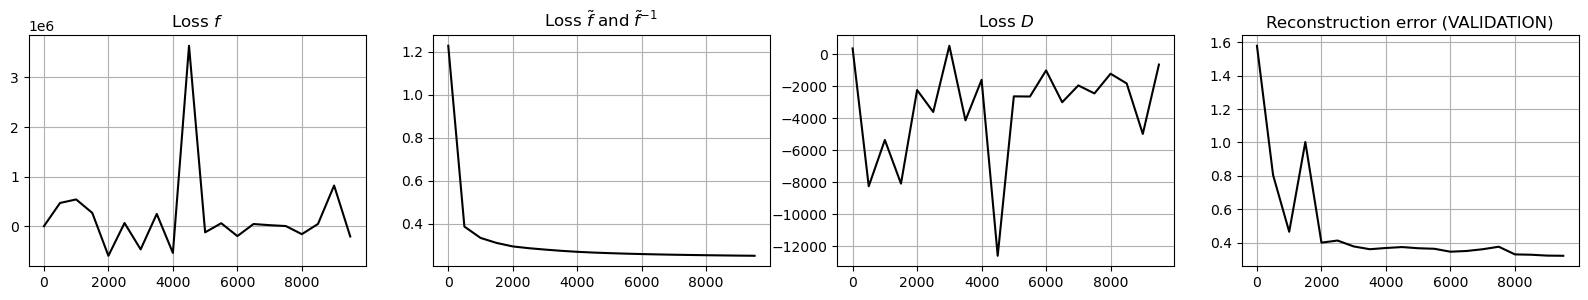

In [29]:
def plot_log(ax, x, y, label):
    ax.plot(x, y, color='black')
    ax.set(title=label)
    ax.grid()

n = 4
fix, ax = plt.subplots(1, n, figsize=(n*5, 3))
x = np.arange(0, len(LOG2)) * log_frequency 

plot_log(ax[0], x, LOG2[:, 0], label='Loss $f$')
plot_log(ax[1], x, LOG2[:, 1],  label='Loss $\\tilde{f}$ and $\\tilde{f}^{-1}$')
plot_log(ax[2], x, LOG2[:, 2],  label='Loss $D$')
plot_log(ax[3], x, LOG2[:, 3],  label='Reconstruction error (VALIDATION)')

In [30]:
results_dic = {"X_Axis":[],
               "Mode":[],
               "Loss $f$":[],
               "Loss $\\tilde{f}$ and $\\tilde{f}^{-1}$":[],
               "Loss $D$":[],
               "Reconstruction error (VALIDATION)":[]}

results_dic = update_results(results_dic, LOG2, log_frequency = 500, mode = "Defense")
df2 = pd.DataFrame(results_dic)
df2.to_csv("/kaggle/working/Defense_Logs.csv")
print("DEFENSE LOG SAVED!")

DEFENSE LOG SAVED!


## Malicious Reconstruction with Defense Technique

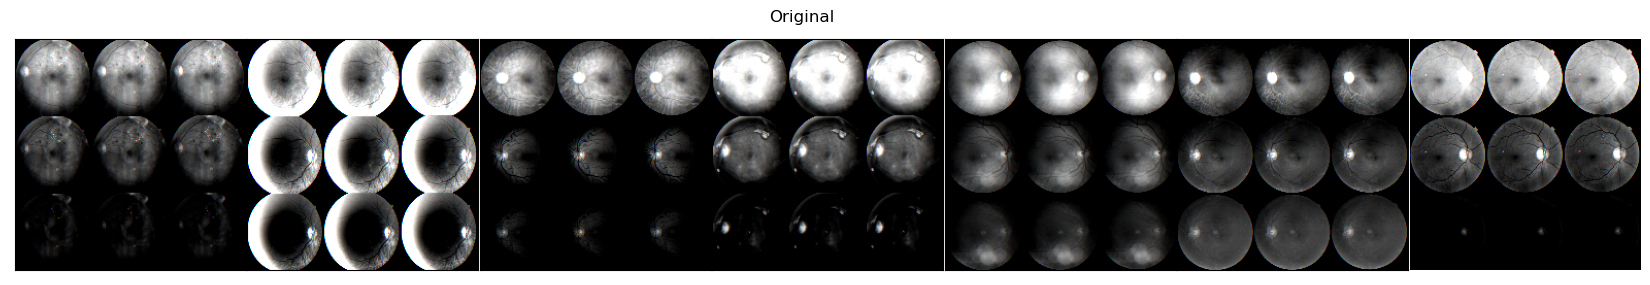

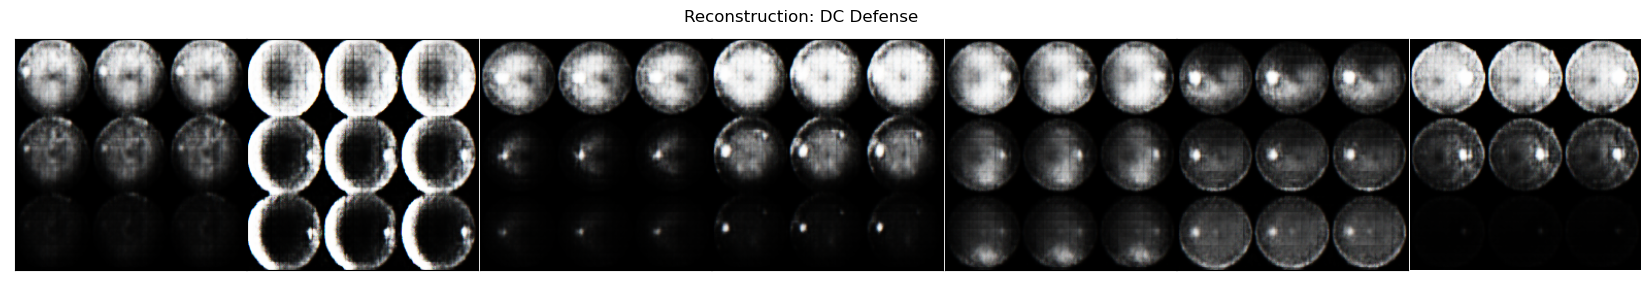

In [31]:
n = 7
X = SplitNN_FSHA.datasets.getImagesDS(XD_priv, n)

X_recovered_defense, control = fsha_defense.attack(X)

def plot(X, title):
    n = len(X)
    X = (X+1)/2
#     plt.title("Cunt")
    fig, ax = plt.subplots(1, n, figsize=(n*3,3))
    fig.suptitle(title)
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-.05)
    for i in range(n):
        ax[i].imshow((X[i]), cmap='inferno');  
        ax[i].set(xticks=[], yticks=[])
        ax[i].set_aspect('equal')
        
    return fig


fig = plot(X, "Original")
plt.savefig('/kaggle/working/Original2.pdf')
plt.savefig('/kaggle/working/Original2.png')
fig = plot(X_recovered_defense, "Reconstruction: DC Defense")
plt.savefig('/kaggle/working/Reconstruction_Defense.png')
plt.savefig('/kaggle/working/Reconstruction_Defense.pdf')

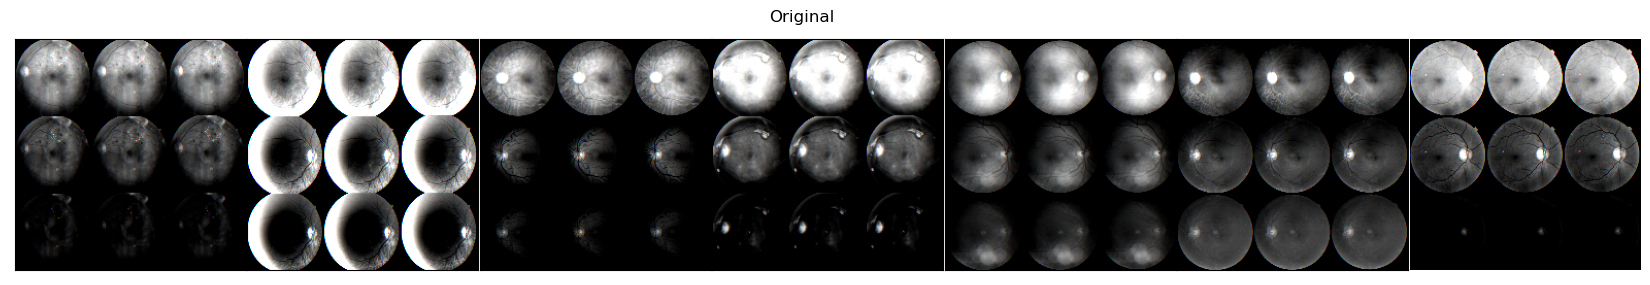

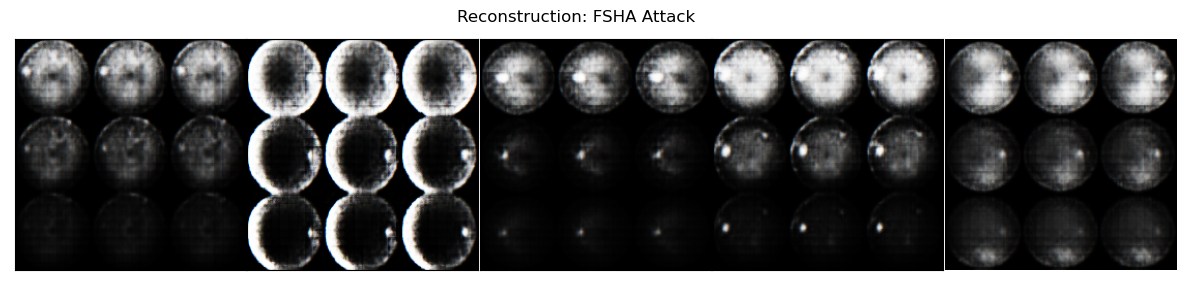

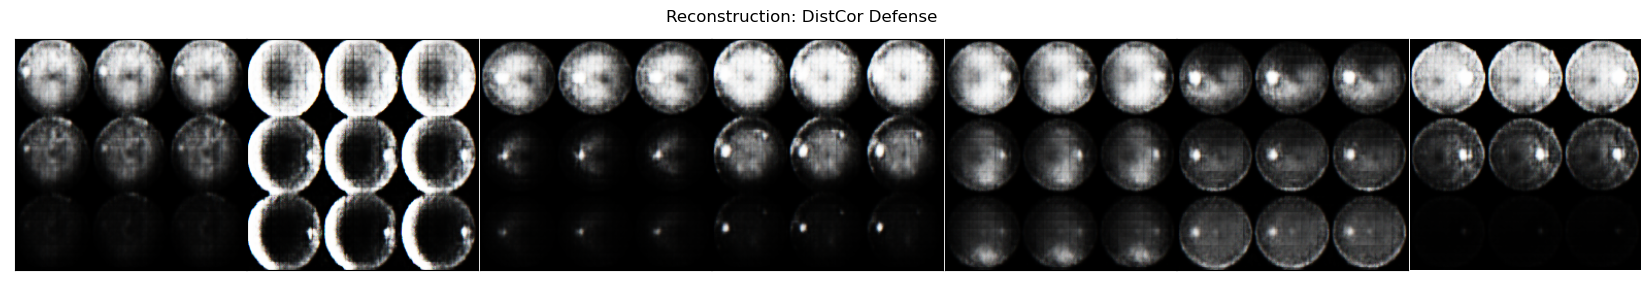

In [32]:
fig = plot(X, "Original")
fig = plot(X_recovered_attack, "Reconstruction: FSHA Attack")
fig = plot(X_recovered_defense, "Reconstruction: DistCor Defense")